<a href="https://colab.research.google.com/github/viacheslav-konstantinov/MADE_NLP/blob/master/homework03_Neural_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework №3

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [2]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip install subword-nmt
! pip install nltk
! pip install torchtext

In [7]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


## Main part - Baseline
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [0]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [0]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [0]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [12]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [0]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [14]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9241
Unique tokens in target (en) vocabulary: 6710


Here are tokens from original (RU) corpus:

In [15]:
SRC.vocab.itos[::1000]

['<unk>',
 '90',
 'роскошных',
 'ионическое',
 'этажа',
 'улучшенный',
 'lotus',
 'уходить',
 'джойоза',
 'тонг']

And from target (EN) corpus:

In [16]:
TRG.vocab.itos[::1000]

['<unk>',
 'added',
 'bratislava',
 'chianti',
 'native',
 'snowshoe',
 'marketplace']

And here is example from train dataset:

In [15]:
print(vars(train_data.examples[9]))

{'trg': ['ski', 'lodge', 'is', 'a', 'holiday', 'home', 'located', 'in', 'the', 'centre', 'of', 'brides', '-', 'les', '-', 'bains', ',', 'a', '2', '-', 'minute', 'walk', 'from', 'olympe', 'gondola', '.'], 'src': ['дом', 'для', 'отпуска', 'ski', 'lodge', 'находится', 'в', 'центре', 'горнолыжного', 'курорта', 'брид', '-', 'ле', '-', 'бен', ',', 'в', '2', 'минутах', 'ходьбы', 'от', 'гондольного', 'подъемника', 'олимп', '.']}


Let's check the length distributions:

Length distribution in Train data


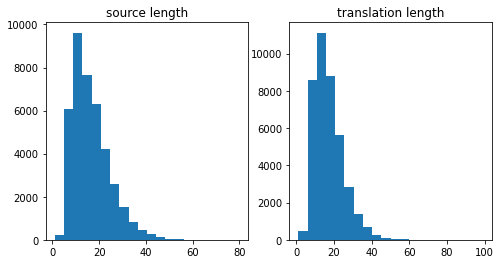

In [17]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


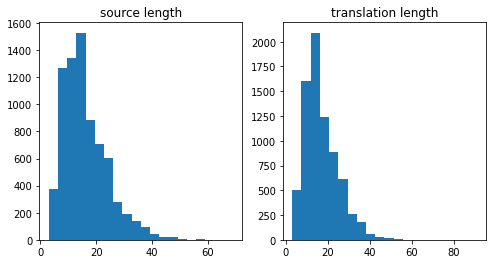

In [18]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
device

device(type='cuda')

In [0]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [22]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 43x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 42x128 (GPU 0)]
torch.Size([42, 128]) torch.Size([43, 128])


In [25]:
%cd "/content/drive/My Drive/MADE_2019/NLP_3"

/content/drive/My Drive/MADE_2019/NLP_3


In [0]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [28]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9241, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6710, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6710, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,882,102 trainable parameters


In [0]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [0]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

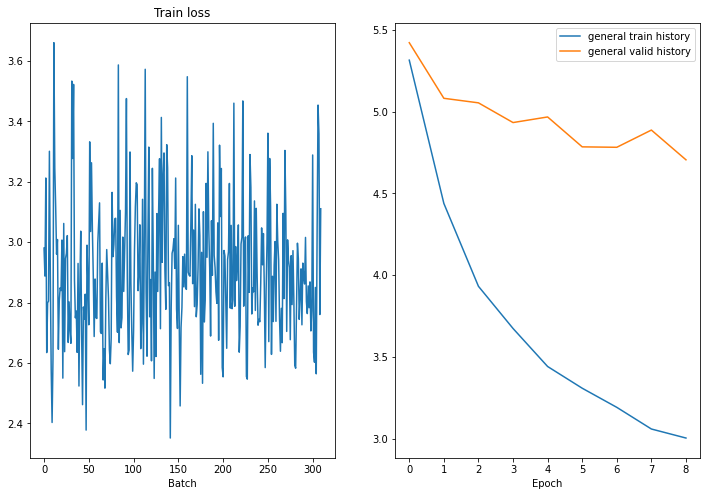

Epoch: 10 | Time: 1m 23s
	Train Loss: 2.909 | Train PPL:  18.342
	 Val. Loss: 4.643 |  Val. PPL: 103.884


In [0]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [0]:
import utils
import imp

imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [0]:
batch = next(iter(test_iterator))

In [0]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: all rooms come with a tv .
Generated: each room is equipped with a flat - screen tv .

Original: there is a 24 - hour front desk at the property .
Generated: 24 - hour front desk .



In [0]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [0]:
import tqdm

In [0]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:03, 16.75it/s]


In [0]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

14.493474507145942

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points

### Other model tests

The main idea is to try different Transofrmer networks as they seem to be the most appropriate netowrk for the task. Due to the lack of time, I just tried two pretrained models without training them and implemented my own. One could try to train pre-trained models or use something more simple like LSTM, but due to the lack of time, these options were not tested.

## 1. OpenNMT-based Transofmer model

The model below is a OpenNMT-based Transform model taken from here: https://github.com/ManiaCello/en-ru-onmt. The model was train with the courpus formed by mixed data from http://opus.nlpl.eu/ and https://translate.yandex.ru/corpus.

In [0]:
!pip install OpenNMT-py

     |████████████████████████████████| 194kB 2.7MB/s 
     |████████████████████████████████| 51kB 2.8MB/s 
     |████████████████████████████████| 61kB 3.5MB/s 
     |████████████████████████████████| 61kB 5.0MB/s 
     |████████████████████████████████| 51kB 3.5MB/s 
     |████████████████████████████████| 2.2MB 4.0MB/s 
  Created wheel for configargparse: filename=ConfigArgParse-1.2.3-cp36-none-any.whl size=19328 sha256=ae36ea3cef2ca2857345d73e88b15444fc5d38078ed037c89479006694ea8b8f
  Stored in directory: /root/.cache/pip/wheels/bd/d6/53/034032da9498bda2385cd50a51a289e88090b5da2d592b1fdf
Successfully built configargparse
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.30.0 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [0]:
%cd "/content/drive/My Drive/MADE_2019/NLP_3"

/content/drive/My Drive/MADE_2019/NLP_3


In [0]:
!git clone https://github.com/ManiaCello/en-ru-onmt

Cloning into 'en-ru-onmt'...
remote: Enumerating objects: 50, done.
remote: Total 50 (delta 0), reused 0 (delta 0), pack-reused 50
Unpacking objects: 100% (50/50), done.


In [0]:
%cd en-ru-onmt

/content/drive/My Drive/MADE_2019/NLP_3/en-ru-onmt


In [0]:
!git clone https://github.com/OpenNMT/OpenNMT-py.git

Cloning into 'OpenNMT-py'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 15965 (delta 6), reused 10 (delta 4), pack-reused 15941
Receiving objects: 100% (15965/15965), 146.74 MiB | 14.09 MiB/s, done.
Resolving deltas: 100% (11524/11524), done.
Checking out files: 100% (204/204), done.
python3: can't open file 'setup.py': [Errno 2] No such file or directory


In [0]:
%cd OpenNMT-py
!python setup.py install
%cd ..

/content/drive/My Drive/MADE_2019/NLP_3/en-ru-onmt/OpenNMT-py
running install
running bdist_egg
running egg_info
creating OpenNMT_py.egg-info
writing OpenNMT_py.egg-info/PKG-INFO
writing dependency_links to OpenNMT_py.egg-info/dependency_links.txt
writing entry points to OpenNMT_py.egg-info/entry_points.txt
writing requirements to OpenNMT_py.egg-info/requires.txt
writing top-level names to OpenNMT_py.egg-info/top_level.txt
writing manifest file 'OpenNMT_py.egg-info/SOURCES.txt'
writing manifest file 'OpenNMT_py.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/onmt
copying onmt/__init__.py -> build/lib/onmt
copying onmt/model_builder.py -> build/lib/onmt
copying onmt/opts.py -> build/lib/onmt
copying onmt/train_single.py -> build/lib/onmt
copying onmt/trainer.py -> build/lib/onmt
creating build/lib/onmt/bin
copying onmt/bin/__init__.py -> build/lib/onmt/bin
copying onmt

The model works with a simple use of a bash script. One needs to provide paths for input and output text files: input file is to translate, output is the result

In [0]:
!sudo ./translate.sh data/gramma.en.txt data/gramma.ru.txt

Токенизация...
Tokenizer Version 1.1
Language: en
Number of threads: 6
Сегментация...
Перевод...
Десегментация перевода...
Детокенизация перевода...
Detokenizer Version $Revision: 4134 $
Language: ru
Перевод выполнен!


In [0]:
#data/data.en.txt is a raw data file
!sudo ./translate.sh data/data.en.txt data/data.ru.txt

Токенизация...
Tokenizer Version 1.1
Language: en
Number of threads: 6
Сегментация...
Перевод...
Десегментация перевода...
Детокенизация перевода...
Detokenizer Version $Revision: 4134 $
Language: ru
Перевод выполнен!


In [0]:
#forming list to calculte BLEU
original_text = []
with open('data/data.en.txt', 'r') as f:
    original_text = [line.strip().split('\t')[1].split(' ') for line in f]
translated_text = []
with open('data/data.ru.txt', 'r') as f:
    translated_text = [line.strip().split(' ') for line in f]

Let's check the translation

In [0]:
original_text[32]

['Все',
 'номера',
 'располагают',
 'собственной',
 'ванной',
 'комнатой',
 'с',
 'душем',
 'и',
 'феном.']

In [0]:
translated_text[32]

['Во',
 'всех',
 'апартаментах',
 'также',
 'имеется',
 'собственная',
 'ванная',
 'комната',
 'с',
 'душем,',
 'оснащенной',
 'феном.']

In [0]:
corpus_bleu([[text] for text in translated_text], original_text) * 100

20.245753161023725

Quite good translation and score, taking in account, that the model wasn't trained with data from the translated text, but I expected a bit more. I guess that one could improve the score by traing more with the data from the original text. I did not do that due to a catastrophic lack of time.

## 2. Own network

Let's try to implement own network. It is Seq2Seq like the baseline, but with attention.

These libraries are needed to implement better Tokenizer for Russian and English with spacy.

https://github.com/buriy/spacy-ru

https://spacy.io/usage/models#download-pip

In [1]:
!pip install spacy-stanza
!pip install pymorphy2==0.8
!git clone -b v2.1 https://github.com/buriy/spacy-ru.git && cp -r ./spacy-ru/ru2/. ./content/ru2
!pip install --upgrade torchtext
!pip install spacy

fatal: destination path 'spacy-ru' already exists and is not an empty directory.
Requirement already up-to-date: torchtext in /usr/local/lib/python3.6/dist-packages (0.6.0)


In GRU_with_attention, there are implemented Encoder, Decoder, Attention, and based on them Seq2Seq network. 

In [2]:
%cd "/content/drive/My Drive/MADE_2019/NLP_3"
from GRU_with_attention import *

/content/drive/My Drive/MADE_2019/NLP_3


In [3]:
%cd /content/
from torchtext.data import Field, BucketIterator, TabularDataset
import spacy

/content


In [4]:
import spacy.cli
spacy.cli.download("en")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [5]:
##checking how ru2 tokenizes Russian
nlp = spacy.load("./spacy-ru/ru2")
sample_sentences = "Привет Миру! Как твои дела? Сегодня неплохая погода."
nlp.add_pipe(nlp.create_pipe('sentencizer'), first=True)
doc = nlp(sample_sentences)
for s in doc.sents:
  print(list(['lemma "{}" from text "{}"'.format(t.lemma_, t.text) for t in s]))

['lemma "привет" from text "Привет"', 'lemma "мир" from text "Миру"', 'lemma "!" from text "!"']
['lemma "как" from text "Как"', 'lemma "твой" from text "твои"', 'lemma "дело" from text "дела"', 'lemma "?" from text "?"']
['lemma "сегодня" from text "Сегодня"', 'lemma "неплохой" from text "неплохая"', 'lemma "погода" from text "погода"', 'lemma "." from text "."']


In the cells bellow, the code follows the logic of the baseline and in many steps repeates it.

In [0]:
SRC = Field(tokenize = "spacy",
            tokenizer_language="en",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize = "spacy",
            tokenizer_language="./spacy-ru/ru2",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('src', SRC), ('trg', TRG)]
)

In [0]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [11]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [0]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [0]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=lambda x: len(x.src))

In [23]:
%cd "/content/drive/My Drive/MADE_2019/NLP_3"

/content/drive/My Drive/MADE_2019/NLP_3


In [0]:
def init_weights(m: nn.Module):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [26]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ATTN_DIM = 64
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5


enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
attn = Attention(ENC_HID_DIM, DEC_HID_DIM, ATTN_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
model = Seq2Seq(enc, dec, device).to(device)

model.apply(init_weights)
optimizer = optim.Adam(model.parameters())

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 37,589,228 trainable parameters


In [30]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10323, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attention): Linear(in_features=1536, out_features=64, bias=True)
    )
    (embedding): Embedding(14252, 256)
    (rnn): GRU(1280, 512)
    (out): Linear(in_features=1792, out_features=14252, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)


In [0]:
PAD_IDX = TRG.vocab.stoi['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [0]:
import math
import time


def train(model: nn.Module,
          iterator: BucketIterator,
          optimizer: optim.Optimizer,
          criterion: nn.Module,
          clip: float):

    model.train()

    epoch_loss = 0

    for _, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output = model(src, trg)

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)


def evaluate(model: nn.Module,
             iterator: BucketIterator,
             criterion: nn.Module):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for _, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)


def epoch_time(start_time: int,
               end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [0]:
N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

Epoch: 01 | Time: 3m 6s
	Train Loss: 5.050 | Train PPL: 156.009
	 Val. Loss: 5.446 |  Val. PPL: 231.907
Epoch: 02 | Time: 3m 7s
	Train Loss: 3.819 | Train PPL:  45.580
	 Val. Loss: 5.022 |  Val. PPL: 151.683
Epoch: 03 | Time: 3m 6s
	Train Loss: 3.301 | Train PPL:  27.145
	 Val. Loss: 4.749 |  Val. PPL: 115.513
Epoch: 04 | Time: 3m 5s
	Train Loss: 2.896 | Train PPL:  18.108
	 Val. Loss: 4.722 |  Val. PPL: 112.341
Epoch: 05 | Time: 3m 5s
	Train Loss: 2.564 | Train PPL:  12.982
	 Val. Loss: 4.679 |  Val. PPL: 107.706
Epoch: 06 | Time: 3m 6s
	Train Loss: 2.258 | Train PPL:   9.563
	 Val. Loss: 4.662 |  Val. PPL: 105.815
Epoch: 07 | Time: 3m 4s
	Train Loss: 2.021 | Train PPL:   7.543
	 Val. Loss: 4.687 |  Val. PPL: 108.548
Epoch: 08 | Time: 3m 4s
	Train Loss: 1.848 | Train PPL:   6.349
	 Val. Loss: 4.626 |  Val. PPL: 102.147
Epoch: 09 | Time: 3m 5s
	Train Loss: 1.699 | Train PPL:   5.470
	 Val. Loss: 4.794 |  Val. PPL: 120.778


KeyboardInterrupt: ignored

In [0]:
batch = next(iter(test_iterator))

In [0]:
%cd "/content/drive/My Drive/MADE_2019/NLP_3"

import utils
import imp

imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

/content/drive/My Drive/MADE_2019/NLP_3


In [0]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: помимо этого , можно пользоваться услугами прачечной .
Generated: в отеле предоставляются услуги прачечной .

Original: поблизости предоставляется бесплатная парковка .
Generated: рядом с отелем обустроена бесплатная парковка .



In [0]:
original_text = []
generated_text = []
model.eval()

with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0)
        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])


59it [00:08,  6.63it/s]


In [0]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

27.97463881604319

Just great result. I guess I could get more with more sophisticated approach for training the model.

##3. Another En-Ru Transformer model

The model is EN-RU Transform model from Facebook-FAIR's WMT'19 news translation task submission: https://github.com/pytorch/fairseq/blob/master/examples/wmt19/README.md. A very good point of this model is that it can be easily used via torch.hub.

In [0]:
!pip install fastBPE sacremoses subword_nmt

In [0]:
import torch
en2ru = torch.hub.load('pytorch/fairseq', 'transformer.wmt19.en-ru.single_model', tokenizer='moses', bpe='fastbpe')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
en2ru.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_fairseq_master


GeneratorHubInterface(
  (models): ModuleList(
    (0): TransformerModel(
      (encoder): TransformerEncoder(
        (embed_tokens): Embedding(31640, 1024, padding_idx=1)
        (embed_positions): SinusoidalPositionalEmbedding()
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fc1): Linear(in_features=1024, out_features=8192, bias=True)
            (fc2): Linear(in_features=8192, out_features=1024, bias=True)
            (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=T

In [0]:
def translate_text(model, text):
  source_tokens = ' '.join(text.src)
  source_bpe = model.apply_bpe(source_tokens)
  source_binary = model.binarize(source_bpe)

  target_binary = model.generate(
      source_binary, 
      beam=5, 
      sampling=True, 
      sampling_topk=20
      )

  target_sample = target_binary[0]['tokens']
  target_bpe = model.string(target_sample)
  target_tokens = model.remove_bpe(target_bpe)
  return target_tokens.split()

In [0]:
print(test_data.examples[5].src)
print(translate_text(en2ru, test_data.examples[5]))

['it', 'offers', 'accommodation', 'with', 'free', 'wi', '-', 'fi', 'and', 'private', 'parking', '.']
['Предлагает', 'проживание', 'с', 'бесплатным', 'wi', '@-@', 'fi', 'и', 'частная', 'парковка', '.']


In [0]:
original_text  = [each_text.trg for each_text in test_data.examples]
generated_text = [translate_text(en2ru, each_text) for each_text in test_data.examples]

In [31]:
print(original_text[120])
print(generated_text[120])

['все', 'апартаменты', 'комплекса', 'innsbrook', 'village', 'оснащены', 'телевизором', 'с', 'кабельными', 'каналами', ',', 'dvd', '-', 'плеером', 'и', 'стиральной', '/', 'сушильной', 'машиной', ',', 'а', 'также', 'располагают', 'кухней', 'с', 'обеденной', 'зоной', '.']
['Во', 'всех', 'квартирах', 'деревни', 'Сбрук', 'есть', 'кабельное', 'телевидение', 'с', 'плеером', ',', 'кухня', 'со', 'столовой', 'и', 'стиральной', 'машиной', 'и', 'сушильной', 'камерой', '.']


In [0]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

16.45585234403999

Good, but not an exceptional result. If to train more, one could obtain better score.

## 4. Conclusions

* Two Transformer pre-trained and one Seq2Seq network were tested;

* Pre-trained gave a good score, especially taking in account, that the models hadn't known anything about the dataset. If to continue training them with data from the dataset, they could give even better results;

* Seq2Seq with attentions gave better resuls than pre-trained models, because the models were trained on more wide and less specialized vocabulary. The Seq2Seq network were trained on more specific vocabulary, so knowns it better, i.e. is someway biased in means of the vocabulary;

* I think it would be a productive way to learn the pretrained model with the data and see how it improves score. I also would like to try different approches to learn Seq2Seq network to understand if one can get better result this way;

* The best BLEU score of 28 was obtained with the Seq2Seq newtwok with attention.